<a href="https://colab.research.google.com/github/MykhailoFokin/ML_TextProcessing/blob/master/Text_extraction_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/MykhailoFokin/segmentation

Cloning into 'segmentation'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 289 (delta 3), reused 10 (delta 2), pack-reused 278
Receiving objects: 100% (289/289), 395.83 MiB | 33.03 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (394/394), done.


In [0]:
!pip install segmentation-models

In [0]:
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import numpy as np

import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
WORKDIR = 'segmentation'
BACKBONE = 'resnet34'
CLASSES = ['score', 'stat', 'username']

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights='imagenet')

85524480/85521592 [==============================] - 3s 0us/step


In [0]:
modelv1 = os.path.join(WORKDIR, 'best_model_v1.h5')
modelv2 = os.path.join(WORKDIR, 'best_model_last2_640.h5')
modelv3 = os.path.join(WORKDIR, 'best_model_last2_last_640.h5')
modelv4 = os.path.join(WORKDIR, 'best_model_checkpoint.h5')

model_weights = modelv4

model.load_weights(model_weights) 

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)

    return x

1/1 [==============================] - 10s 10s/step


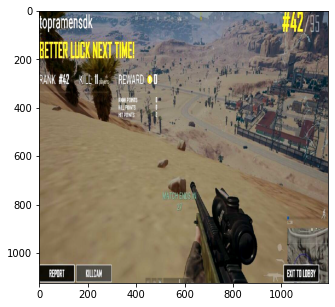

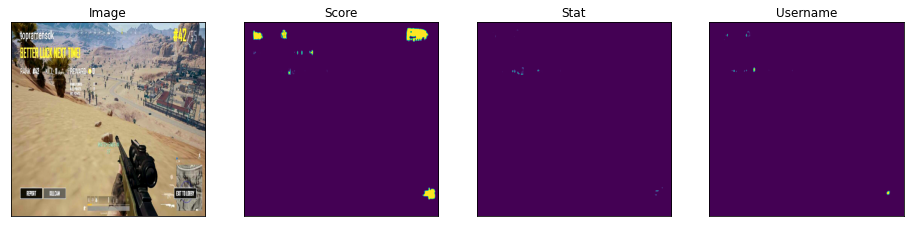

1/1 [==============================] - 9s 9s/step


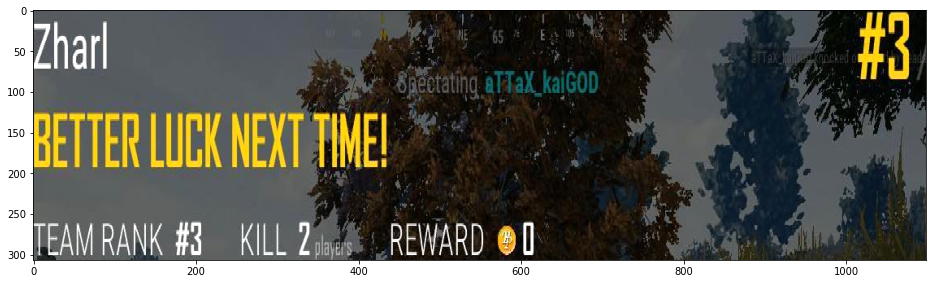

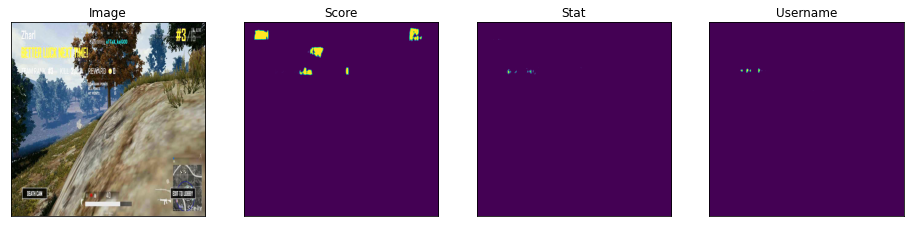

1/1 [==============================] - 9s 9s/step


In [0]:
SHOW_IMAGE_COUNT = 2

!mkdir '$WORKDIR/datasets/cropped_images'

## Read an image and crop it
new_size = (1280,1280) # prefferable image size

## TO DO
modelv1 = os.path.join(WORKDIR, 'best_model_v1.h5')
modelv2 = os.path.join(WORKDIR, 'best_model_last2_640.h5')
modelv3 = os.path.join(WORKDIR, 'best_model_last2_last_640.h5')
modelv4 = os.path.join(WORKDIR, 'best_model_last2_last_640.h5')

model_weights = modelv4

model.load_weights(model_weights) 

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k/ncol, k%ncol

threshold = 0.5

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'pubg')):
    for file in f:
        if '.jpg' in file:
            #if ('pubg_144.jpg'!=file):
              files.append(file)
              #print(file)
              image = None
              
              image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'pubg',file))
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              image = cv2.resize(image, new_size, interpolation = cv2.INTER_NEAREST)
              image2 = np.expand_dims(image, axis=0)
              #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

              prediction = model.predict(image2, verbose=1)
              mask = (prediction[0, ..., 1] > threshold).astype(np.uint8)
              x,y,w,h = cv2.boundingRect(mask)

              crop_img = image[y:y+h, x:x+w]
              #img_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
              #img_gray = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)

              if SHOW_IMAGE_COUNT>0 :
                plt.figure(figsize=(16, 5))
                plt.imshow(denormalize(crop_img.squeeze()))
                plt.show()

               # plt.figure(figsize=(16, 5))
               # plt.imshow(denormalize(img_gray.squeeze()))
               # plt.show()

                visualize(
                    image=denormalize(image.squeeze()),
                    #predictions=np.maximum(prediction[..., 1].squeeze(),prediction[..., 2].squeeze(),prediction[..., 3].squeeze()),
                    score=prediction[..., 1].squeeze(),
                    stat=prediction[..., 2].squeeze(),
                    username=prediction[..., 3].squeeze(),
                )
                SHOW_IMAGE_COUNT-=1;

                #break

              for i, class_name in enumerate(CLASSES) :
                mask = (prediction[0, ..., i+1] > threshold).astype(np.uint8)
                x,y,w,h = cv2.boundingRect(mask)
                if (w!=0 and h!=0) :
                  crop_img = image[y:y+h, x:x+w]
                  cv2.imwrite(os.path.join(WORKDIR, 'datasets', 'cropped_images', class_name + '_' + file), crop_img)


# crop source file - result image for further processing (text recognition)
#cropped_image = image[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]

# Recognize text using [pytesseract](https://pypi.org/project/pytesseract/) and compare with truth values. 
# It could be that for most segments score could be recognized wrong. Try to apply preprocessing for segments according to this [article](https://tesseract-ocr.github.io/tessdoc/ImproveQuality).
# Next is model improvement 
# generate box files with text and manually fix it
# train model using tesseract
# check results

### Download cropped images

In [0]:
!zip -r ./segmentation/datasets/cropped_images/cropped_images.zip ./segmentation/datasets/cropped_images/

  adding: segmentation/datasets/cropped_images/ (stored 0%)
  adding: segmentation/datasets/cropped_images/stat_pubg_100.jpg (deflated 29%)
  adding: segmentation/datasets/cropped_images/stat_pubg_185.jpg (deflated 33%)
  adding: segmentation/datasets/cropped_images/username_pubg_167.jpg (deflated 0%)
  adding: segmentation/datasets/cropped_images/username_pubg_113.jpg (deflated 1%)
  adding: segmentation/datasets/cropped_images/score_pubg_137.jpg (deflated 3%)
  adding: segmentation/datasets/cropped_images/score_pubg_165.jpg (deflated 0%)
  adding: segmentation/datasets/cropped_images/score_pubg_120.jpg (deflated 1%)
  adding: segmentation/datasets/cropped_images/stat_pubg_115.jpg (deflated 2%)
  adding: segmentation/datasets/cropped_images/username_pubg_104.jpg (deflated 6%)
  adding: segmentation/datasets/cropped_images/username_pubg_136.jpg (deflated 6%)
  adding: segmentation/datasets/cropped_images/score_pubg_153.jpg (deflated 1%)
  adding: segmentation/datasets/cropped_images/us

In [0]:
# download 
from google.colab import files
files.download(os.path.join(WORKDIR, 'datasets', 'cropped_images',"cropped_images.zip"))

In [0]:
!sudo add-apt-repository ppa:alex-p/tesseract-ocr-devel -y
!sudo apt-get update
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install Pillow
!pip install pytesseract

Get:1 http://ppa.launchpad.net/alex-p/tesseract-ocr-devel/ubuntu bionic InRelease [15.4 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:10 http://ppa.launchpad.net/alex-p/tesseract-ocr-devel/ubuntu bionic/main amd64 Packages [26.0 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64

In [0]:
## Tesseract
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract

#pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'

!tesseract -v

tesseract 5.0.0-alpha-671-g27d51
 leptonica-1.78.0
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.2) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1 : libopenjp2 2.3.0
 Found AVX512BW
 Found AVX512F
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found OpenMP 201511
 Found libarchive 3.2.2 zlib/1.2.11 liblzma/5.2.2 bz2lib/1.0.6 liblz4/1.7.1


### Print examples of tesseract text detection

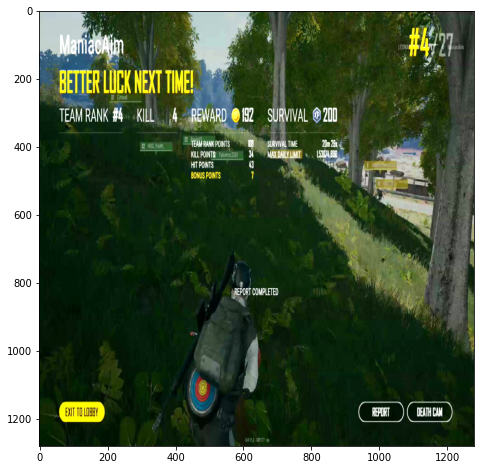

1/1 [==============================] - 9s 9s/step
Examples : SCORE
Image to string. Gray cropped image:
NEWECo iN

Na Uae

TEAM RANK #4

Ae Seen SON VST I

Hd
Image to string. Cropped image (original color):
TE |

uy a rl ud

ST mT

na ae
Image to boxes. Gray cropped image:
N 2 204 29 259 0
E 33 202 50 245 0
W 54 204 71 245 0
E 76 202 101 259 0
C 97 202 110 259 0
o 105 202 188 259 0
i 152 190 171 263 0
N 170 190 189 263 0
N 2 89 20 154 0
a 24 89 118 154 0
U 131 87 210 154 0
a 222 89 301 154 0
e 312 89 392 154 0
T 1 3 14 42 0
E 17 3 29 42 0
A 31 3 45 42 0
M 49 3 66 42 0
R 78 3 91 42 0
A 93 3 108 42 0
N 111 3 125 42 0
K 130 3 143 42 0
# 158 3 173 44 0
4 174 3 186 44 0
A 230 3 265 42 0
e 268 3 279 42 0
S 346 3 347 44 0
e 359 0 372 50 0
e 371 0 385 50 0
n 384 0 393 50 0
S 390 3 458 42 0
O 461 3 530 42 0
N 538 3 571 44 0
V 559 0 589 50 0
S 614 3 643 42 0
T 647 3 697 42 0
I 755 3 816 46 0
H 1029 197 1059 279 0
d 1062 197 1088 279 0
Image to string. Gray cropped image with whitelist(only digi

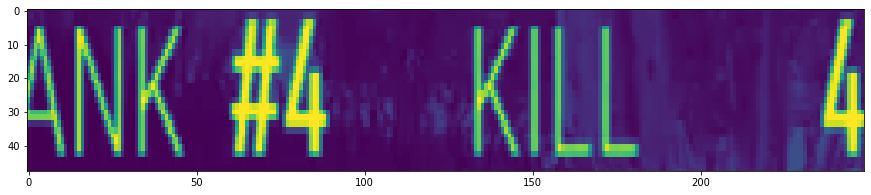

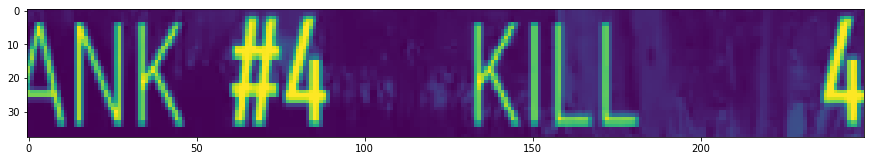

Image to string. Gray cropped image STAT with whitelist(only digits):

Image to string. Gray cropped image(resized) STAT with whitelist(only digits):
#4


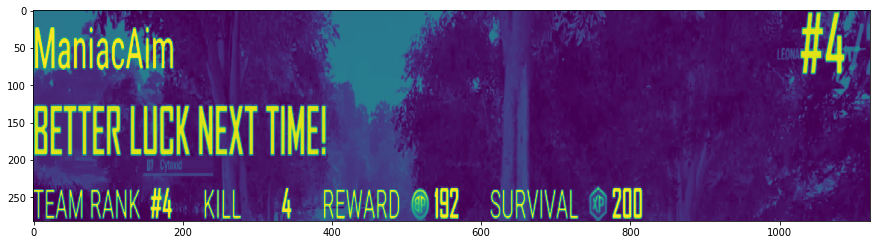

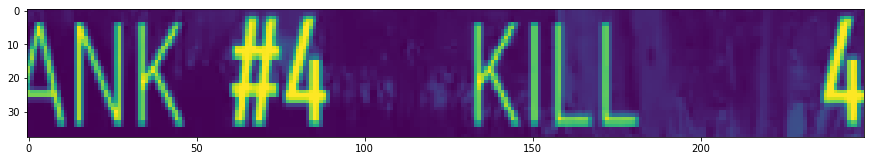

Image to string. Gray cropped image SCORE with whitelist(only digits):

Image to string. Gray cropped image(resized) SCORE with whitelist(only digits):
1
#4 4192#200


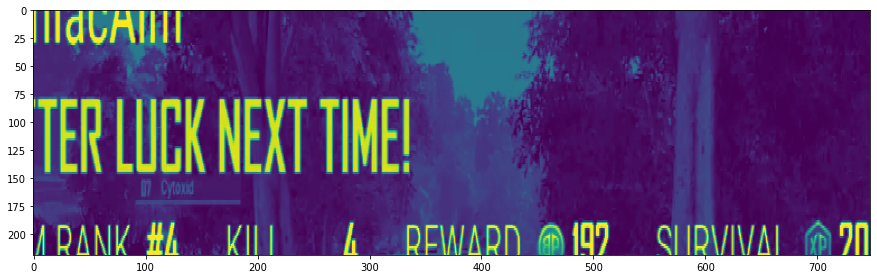

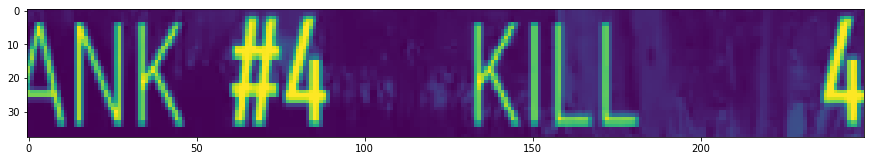

Image to string. Gray cropped image USERNAME with whitelist(only characters):
UhaVtET
TERLUCKNEXTTIME
Image to string. Gray cropped image(resized) USERNAME with whitelist(only characters):
BiiiNietEl
UaaalRatCt


In [0]:
file = 'pubg_183.jpg'

image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'pubg',file))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, new_size, interpolation = cv2.INTER_NEAREST)
image2 = np.expand_dims(image, axis=0)

# Print an image
plt.figure(figsize=(20, 8))
plt.imshow(denormalize(image.squeeze()))
plt.show()

prediction = model.predict(image2, verbose=1)
mask_score    = (prediction[0, ..., 1] > threshold).astype(np.uint8)
mask_stat     = (prediction[0, ..., 2] > threshold).astype(np.uint8)
mask_username = (prediction[0, ..., 3] > threshold).astype(np.uint8)

x1,y1,w1,h1 = cv2.boundingRect(mask_score)
x2,y2,w2,h2 = cv2.boundingRect(mask_stat)
x3,y3,w3,h3 = cv2.boundingRect(mask_username)

crop_img_score    = image[y1:y1+h1, x1:x1+w1]
crop_img_stat     = image[y2:y2+h2, x2:x2+w2]
crop_img_username = image[y3:y3+h3, x3:x3+w3]

# optimal height size for char is 30-33 (tested on tesseract ocr version 4.x)
# source: https://groups.google.com/forum/#!msg/tesseract-ocr/Wdh_JJwnw94/24JHDYQbBQAJ
scale_percent = 50 # percent of original size
text_height = 36
#text_width = img.shape[1]
#text_width = int(img.shape[1] * scale_percent / 100)

#Resize block
crop_img_score_r    = cv2.resize(crop_img_score, (crop_img_score.shape[1], 38 if crop_img_score.shape[0]<130 else int(crop_img_score.shape[0] * scale_percent / 100)),  cv2.COLOR_RGB2GRAY)
crop_img_stat_r     = cv2.resize(crop_img_stat, (crop_img_stat.shape[1], 38 if crop_img_stat.shape[0]<130 else int(crop_img_stat.shape[0] * scale_percent / 100)), cv2.COLOR_RGB2GRAY)
crop_img_username_r = cv2.resize(crop_img_username, (crop_img_username.shape[1], 38 if crop_img_username.shape[0]<130 else int(crop_img_username.shape[0] * scale_percent / 100)), cv2.COLOR_RGB2GRAY)

# Image to gray
img_gray_score    = cv2.cvtColor(crop_img_score, cv2.COLOR_RGB2GRAY)
img_gray_stat     = cv2.cvtColor(crop_img_stat, cv2.COLOR_RGB2GRAY)
img_gray_username = cv2.cvtColor(crop_img_username, cv2.COLOR_RGB2GRAY)

img_gray_score_r    = cv2.cvtColor(crop_img_score_r, cv2.COLOR_RGB2GRAY)
img_gray_stat_r     = cv2.cvtColor(crop_img_stat_r, cv2.COLOR_RGB2GRAY)
img_gray_username_r = cv2.cvtColor(crop_img_username_r, cv2.COLOR_RGB2GRAY)

print("=======================================================================")
for i in range(3) :
  img_gray = img_gray_score if i==0 else img_gray_stat if i==2 else img_gray_username
  crop_img = crop_img_score if i==0 else crop_img_stat if i==2 else crop_img_username
  print("Examples : " + ("SCORE" if i==0 else "STAT" if i==2 else "USERNAME"))
  print("Image to string. Gray cropped image:\n" + pytesseract.image_to_string(img_gray, lang='eng'))
  print("Image to string. Cropped image (original color):\n" + pytesseract.image_to_string(crop_img, lang='eng'))
  print("Image to boxes. Gray cropped image:\n" + pytesseract.image_to_boxes(img_gray, lang='eng'))
  print("Image to string. Gray cropped image with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))
  print("Image to string. Gray cropped image with whitelist(only lowercase characters):\n" + pytesseract.image_to_string(img_gray, lang='eng', config='--psm 6 -c tessedit_char_whitelist="abcdefghijklmnopqrstuvwxyz" lstmbox'))
  print("Image to string. Gray cropped image with whitelist(only characters):\n" + pytesseract.image_to_string(img_gray, lang='eng', config='--psm 6 -c tessedit_char_whitelist="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ" lstmbox'))

  #print("Image to string. Gray cropped image with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray, lang='eng', config='--psm 6 outputbase digits lstmbox'))
  
  print("=======================================================================")
  
print("Image to boxes. Original image (all classes) with whitelist(only digits, psm 6):\n" + pytesseract.image_to_boxes(image, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))
print("Image to boxes. Original image (all classes) with whitelist(only digits, psm 1):\n" + pytesseract.image_to_boxes(image, lang='eng', config='--psm 1 -c tessedit_char_whitelist="01234567890#" lstmbox'))
print("=======================================================================")

plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_stat.squeeze()))
plt.show()
plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_stat_r.squeeze()))
plt.show()
print("Image to string. Gray cropped image STAT with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray_stat, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))
print("Image to string. Gray cropped image(resized) STAT with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray_stat_r, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))

plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_score.squeeze()))
plt.show()
plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_stat_r.squeeze()))
plt.show()
print("Image to string. Gray cropped image SCORE with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray_score, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))
print("Image to string. Gray cropped image(resized) SCORE with whitelist(only digits):\n" + pytesseract.image_to_string(img_gray_score_r, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox'))

plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_username.squeeze()))
plt.show()
plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_stat_r.squeeze()))
plt.show()
print("Image to string. Gray cropped image USERNAME with whitelist(only characters):\n" + pytesseract.image_to_string(img_gray_username, lang='eng', config='--psm 6 -c tessedit_char_whitelist="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ" lstmbox'))
print("Image to string. Gray cropped image(resized) USERNAME with whitelist(only characters):\n" + pytesseract.image_to_string(img_gray_username_r, lang='eng', config='--psm 6 -c tessedit_char_whitelist="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ" lstmbox'))

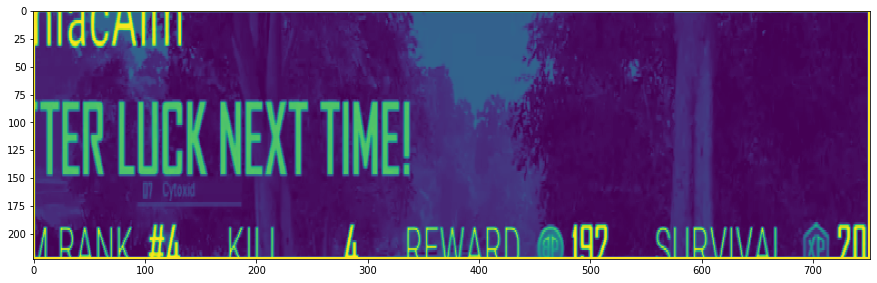

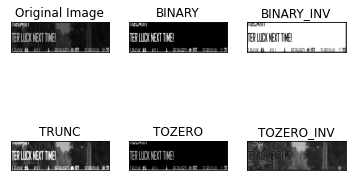

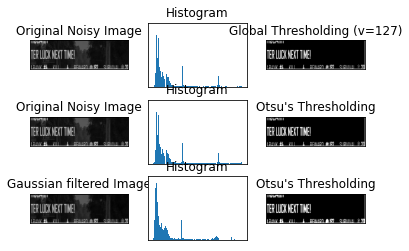

In [0]:
# experiment with preprocessing
img_gray_score    = cv2.cvtColor(crop_img_score, cv2.COLOR_RGB2GRAY)
img_gray_stat     = cv2.cvtColor(crop_img_stat, cv2.COLOR_RGB2GRAY)
img_gray_username = cv2.cvtColor(crop_img_username, cv2.COLOR_RGB2GRAY)

img_gray_score_r    = cv2.cvtColor(crop_img_score_r, cv2.COLOR_RGB2GRAY)
img_gray_stat_r     = cv2.cvtColor(crop_img_stat_r, cv2.COLOR_RGB2GRAY)
img_gray_username_r = cv2.cvtColor(crop_img_username_r, cv2.COLOR_RGB2GRAY)

# add border (can improve recognition quality in some cases)
# source: https://web.archive.org/web/20151209085049/https://code.google.com/p/tesseract-ocr/issues/detail?id=398
bordersize = 2

img_gray_score2 = cv2.copyMakeBorder(
    img_gray_score,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=255
)
img_gray_stat2 = cv2.copyMakeBorder(
    img_gray_stat,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=255
)
img_gray_username2 = cv2.copyMakeBorder(
    img_gray_username,
    top=bordersize,
    bottom=bordersize,
    left=bordersize,
    right=bordersize,
    borderType=cv2.BORDER_CONSTANT,
    value=255
)

plt.figure(figsize=(15, 5))
plt.imshow(denormalize(img_gray_username2.squeeze()))
plt.show()

# Simple Thresholding
# source: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html
img=img_gray_username2

ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    #plt.figure(figsize=(15, 5))
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


# Otsu's Binarization
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


##First run of tesseract on cropped images

- got an lstmbox files
- download them for fixing errors

In [0]:
!mkdir '$WORKDIR/datasets/cropped_images/lstmbox'

for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'cropped_images')):
    for file in f:
        if '.jpg' in file:
          image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'cropped_images',file))
          img_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
          #image = cv2.resize(image, new_size, interpolation = cv2.INTER_NEAREST)

          if (file.startswith('username')) :
            boxes = pytesseract.image_to_boxes(image, lang='eng', config='--psm 6 lstmbox')
          else :
            boxes = pytesseract.image_to_boxes(image, lang='eng', config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox')
          ###  Write to Text File ######
          #file = open(os.path.join(WORKDIR, 'datasets', 'pubg', file[:-3]+"txt"),"w")
          #file.write(boxes.encode('utf-8'))
          with open(os.path.join(WORKDIR, 'datasets', 'cropped_images','lstmbox', file[:-3]+"txt"),'w') as f: f.write(str(boxes))

mkdir: cannot create directory ‘segmentation/datasets/cropped_images/lstmbox’: No such file or directory


### Download to local drive for manual review

In [0]:
!zip -r ./segmentation/datasets/cropped_images/lstmbox.zip ./segmentation/datasets/cropped_images/lstmbox
from google.colab import files
files.download(os.path.join(WORKDIR, 'datasets', 'cropped_images',"lstmbox.zip"))

### Crop images based on manual segmentation

In [0]:
from pycocotools.coco import COCO
from tqdm import tqdm

!mkdir '$WORKDIR/datasets/cropped_images_manual'

CLASSES = {'score':1, 'stat':2, 'username':3}

coco = COCO(os.path.join(WORKDIR, 'pubg.json'))

cat_ids = coco.getCatIds(catNms=['games'])
img_ids = coco.getImgIds(catIds=cat_ids)
imgs = coco.loadImgs(img_ids)

masks = []
for img in tqdm(imgs, 'Crop images'):
    ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((img['height'], img['width']))
    for ann in anns:
        image = cv2.imread(os.path.join(os.path.join(WORKDIR, 'datasets', 'pubg'), img['file_name']))
        x,y,w,h = ann["bbox"]
        if (w!=0 and h!=0) :
          crop_img = image[y:y+h, x:x+w]
          cv2.imwrite(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual', ann['metadata']['name'] + '_' + img['file_name'][:-3]+"png"), crop_img)

Crop images:   1%|          | 1/89 [00:00<00:12,  7.16it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Crop images: 100%|██████████| 89/89 [00:05<00:00, 15.68it/s]


In [0]:
# download manual cropped images
!zip -r ./segmentation/datasets/cropped_images_manual/cropped_images_manual.zip ./segmentation/datasets/cropped_images_manual
files.download(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual',"cropped_images_manual.zip"))

# Tesseract proccessing

In [0]:
!mkdir '$WORKDIR/datasets/cropped_images_manual/lstmbox'

In [0]:
import pandas as pd
import math

In [0]:
class TextProcessor:

  def __init__(
            self, 
            work_dir,  
            preprocessing=None,
            prepeocessing_add_border=None,
            print_first_3=False,
            preprocessing_resize_3033=None,
    ):
        self.work_dir = work_dir
        self.text_boxes = dict()
        self.preprocessing = preprocessing
        self.prepeocessing_add_border = prepeocessing_add_border
        self.print_first_3 = print_first_3
        self.bordersize = 2
        self.preprocessing_resize_3033=preprocessing_resize_3033
        self.default_model_lang = 'eng'
        self.model_lang = self.default_model_lang

  def process_data(self, process_flag=1) :
    #for r, d, f in os.walk(os.path.join(WORKDIR, 'datasets', 'cropped_images')):
    first_3_counter = 0
    for r, d, f in os.walk(self.work_dir):
        for file in f:
            if '.png' in file:
              image = cv2.imread(os.path.join(self.work_dir, file))
              image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
              #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              #image = cv2.resize(image, new_size, interpolation = cv2.INTER_NEAREST)

              if self.prepeocessing_add_border :
                image = cv2.copyMakeBorder(
                    image,
                    top=self.bordersize,
                    bottom=self.bordersize,
                    left=self.bordersize,
                    right=self.bordersize,
                    borderType=cv2.BORDER_CONSTANT,
                    value=255
                )

              if self.preprocessing == 'BINARY' :
                if 'score' in file :
                  ret,image = cv2.threshold(image,70,255,cv2.THRESH_BINARY)
                else :
                  ret,image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
              elif self.preprocessing == 'OTSU' :
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                ret,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
              elif self.preprocessing == 'OTSU2' :
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                ret,image = cv2.threshold(image,0,255,cv2.THRESH_OTSU)
              elif self.preprocessing == 'BINARY_MANUAL' :
                ret,image = cv2.threshold(image,50,255,cv2.THRESH_BINARY)

              if self.preprocessing_resize_3033 :
                image = cv2.resize(image, (37,37), interpolation = cv2.INTER_NEAREST)

              if process_flag == 1:
                if (file.startswith('username')) :
                  boxes = pytesseract.image_to_boxes(image, lang=self.model_lang, config='--psm 6 lstmbox')
                else :
                  boxes = pytesseract.image_to_boxes(image, lang=self.model_lang, config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox')
              elif process_flag == 2:
                if (file.startswith('username')) :
                  boxes = pytesseract.image_to_string(image, lang=self.model_lang, config='--psm 6 lstmbox')
                else :
                  boxes = pytesseract.image_to_string(image, lang=self.model_lang, config='--psm 6 -c tessedit_char_whitelist="01234567890#" lstmbox')
              else :
                raise Exception('Unknown processing flag {}. Only 1(boxes) and 2(strings) are allowed.'.format(process_flag))

              with open(os.path.join(self.work_dir, 'lstmbox', file[:-3]+"txt"),'w') as f: f.write(str(boxes))
              #self.text_boxes.append(file[:-3], boxes)
              self.text_boxes[file] = boxes

              if self.print_first_3 :
                if first_3_counter<=4 :
                  self.print_recognized(image, boxes)
                  first_3_counter+=1

  def image_text_to_boxes(self, model) :
      if model :
        self.model_lang = model
      self.process_data(1)
      self.model_lang = self.default_model_lang

  def image_text_to_strings(self, model) :
      if model :
        self.model_lang = model
      self.process_data(2)
      self.model_lang = self.default_model_lang

  def text_boxes_to_file(self, zip_and_download = None) :  
    ###  Write to Text File ######
    #with open(os.path.join(self.work_dir, file[:-3]+"txt"),'w') as f: f.write(str(boxes))
    if zip_and_download :
      !zip -r ./segmentation/datasets/cropped_images_manual/lstmbox/lstmbox.zip ./segmentation/datasets/cropped_images_manual/lstmbox
      files.download(os.path.join(self.work_dir, 'lstmbox', "lstmbox.zip"))

  def print_recognized(self, image, boxes) :

      plt.figure(figsize=(10, 5))
      plt.xlabel(boxes, fontsize=14)
      plt.imshow(denormalize(image.squeeze()))
      plt.show()
  
  def print_examples(self, count_of_images) :
    i = 0
    for key in x.text_boxes :
      
      image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual', key))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      if self.preprocessing == 'BINARY' :
        ret,image = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
      elif self.preprocessing == 'OTSU' :
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret,image = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
      elif self.preprocessing == 'OTSU2' :
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret,image = cv2.threshold(image,0,255,cv2.cv2.THRESH_OTSU)

      plt.figure(figsize=(10, 5))
      plt.xlabel(x.text_boxes[key], fontsize=14)
      plt.imshow(denormalize(image.squeeze()),'gray')
      plt.show()

      # Print only a few ones
      if i == count_of_images : 
        break
      else :
        i+=1

  def evaluate_manual(self, class_mask='ALL'):
    ground_truth = pd.read_csv(os.path.join(WORKDIR, 'text_data.csv'), sep='|')
    ground_truth.drop('Unnamed: 0', axis=1, inplace=True)
    ground_truth.drop('Unnamed: 5', axis=1, inplace=True)

    for item in x.text_boxes:
      #print(item)
      str_index = item.find('_')
      source_file_name = item[str_index+1:-3]+'jpg'
      if (class_mask == 'ALL' or item[:str_index] == class_mask) :
        class_name = item[:str_index]
        class_name_eval = class_name + '_eval'
        class_name_tessdata = class_name + '_tessdata'
        #print(source_file_name)
        z = ground_truth.loc[ground_truth['image_name'] == source_file_name][class_name].values[0]
        if z == z :
          z = z.replace(" ", "")
          ground_truth.loc[ground_truth['image_name'] == source_file_name,class_name_tessdata] = x.text_boxes[item]
          if (x.text_boxes[item] == z) :
            ground_truth.loc[ground_truth['image_name'] == source_file_name,class_name_eval] = 1
          else :
            ground_truth.loc[ground_truth['image_name'] == source_file_name,class_name_eval] = 0
        else :
          ground_truth.loc[ground_truth['image_name'] == source_file_name,class_name_tessdata] = 0
          ground_truth.loc[ground_truth['image_name'] == source_file_name,class_name_eval] = 1

      self.eval_table = ground_truth

    return (ground_truth['score_eval'].sum() + ground_truth['stat_eval'].sum() + ground_truth['username_eval'].sum() ) / (ground_truth.shape[0]*3)

In [0]:
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_boxes()

In [0]:
# download files for review
x.text_boxes_to_file(True)

updating: segmentation/datasets/cropped_images_manual/lstmbox/ (stored 0%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/username_pubg_109.txt (deflated 40%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/stat_pubg_115.txt (deflated 27%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/stat_pubg_179.txt (deflated 38%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/stat_pubg_144.txt (deflated 40%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/username_pubg_180.txt (deflated 45%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/stat_pubg_120.txt (deflated 44%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/stat_pubg_167.txt (deflated 47%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/score_pubg_163.txt (stored 0%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/score_pubg_149.txt (deflated 26%)
updating: segmentation/datasets/cropped_images_manual/lstmbox/s

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


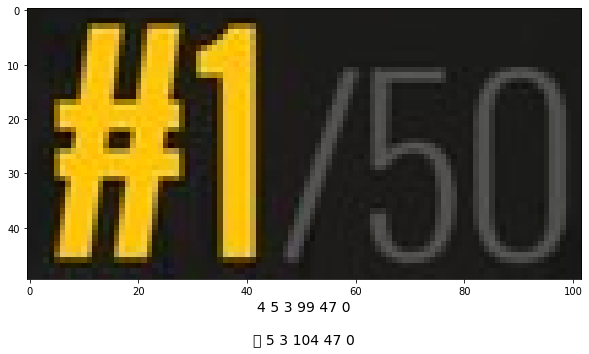

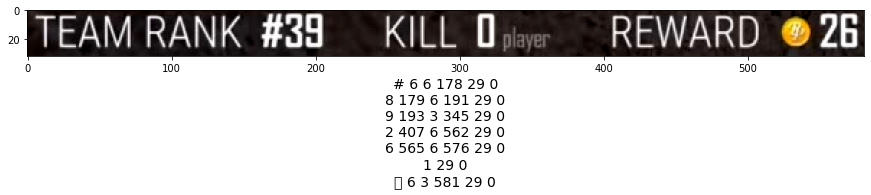

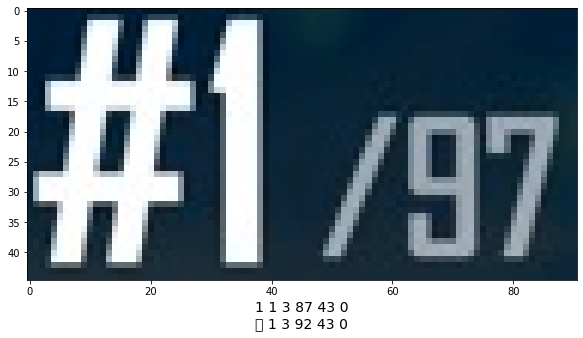

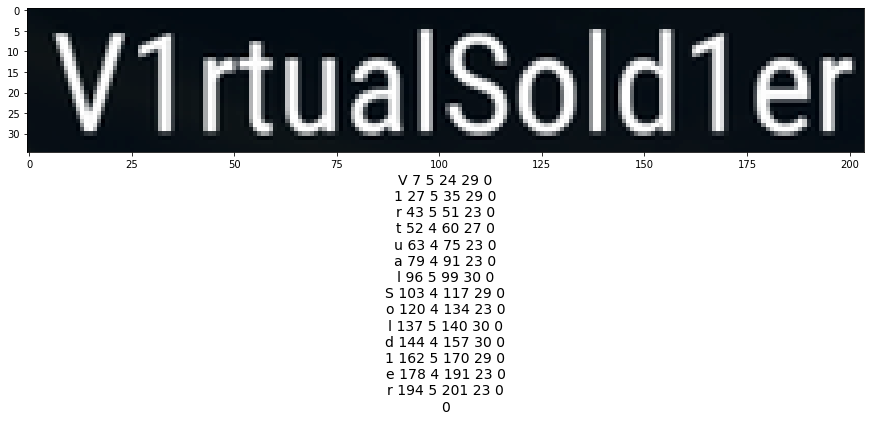

In [0]:
i = 0
for key in x.text_boxes :
  
  image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual', key))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(15, 5))
  plt.xlabel(x.text_boxes[key], fontsize=14)
  plt.imshow(denormalize(image.squeeze()))
  plt.show()

  # Print only a few ones
  if i == 3 : 
    break
  else :
    i+=1

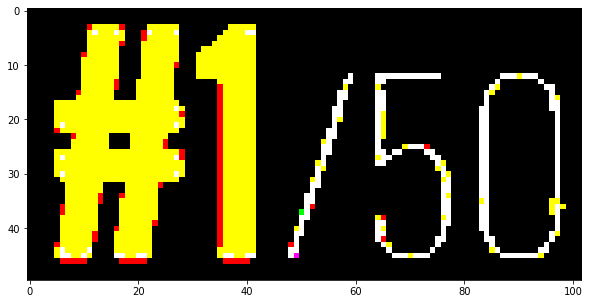

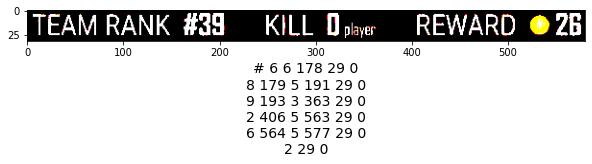

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


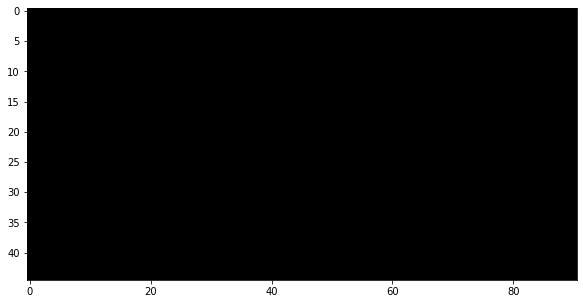

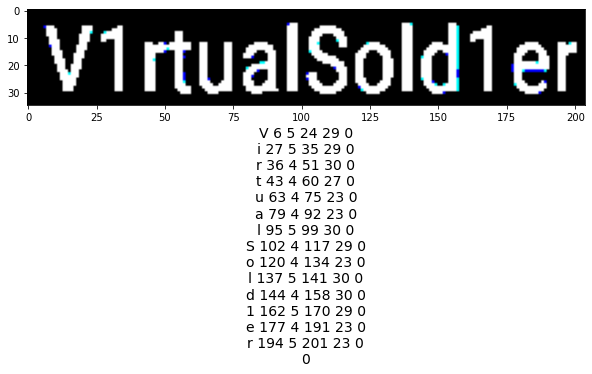

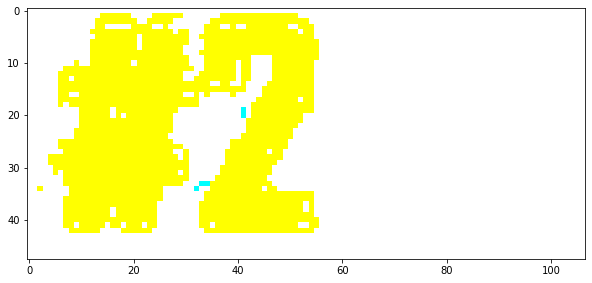

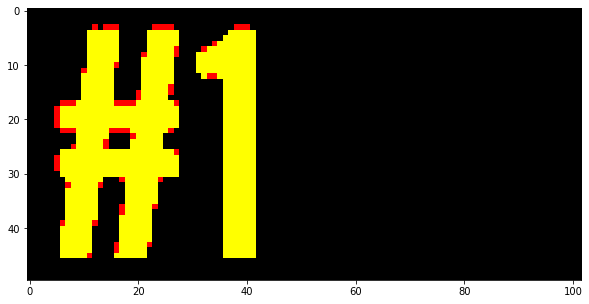

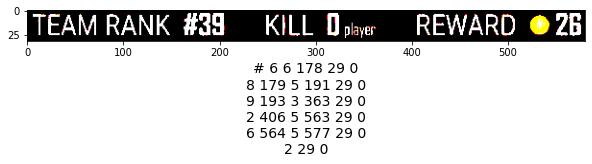

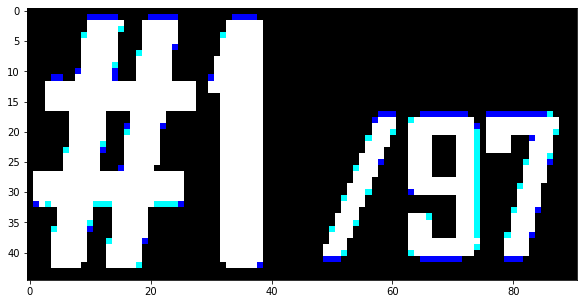

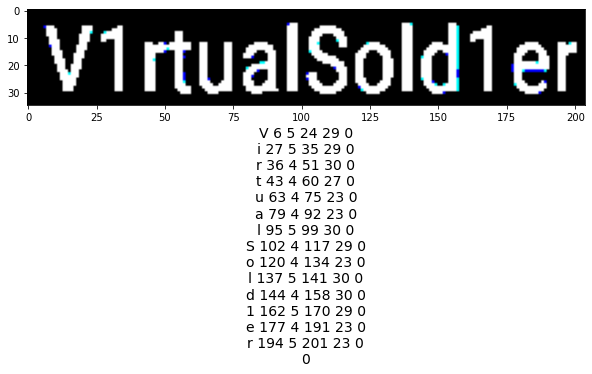

In [0]:
# Apply preprocessing (BINARY)
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'),'BINARY', None, True)

x.image_text_to_boxes()
x.print_examples(3)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


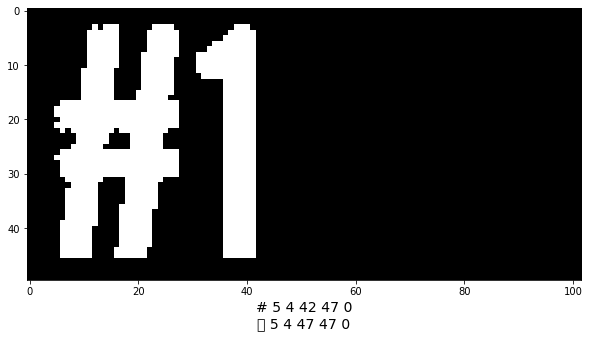

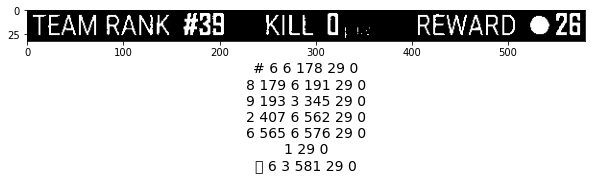

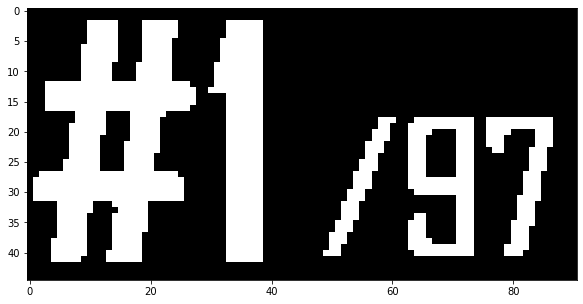

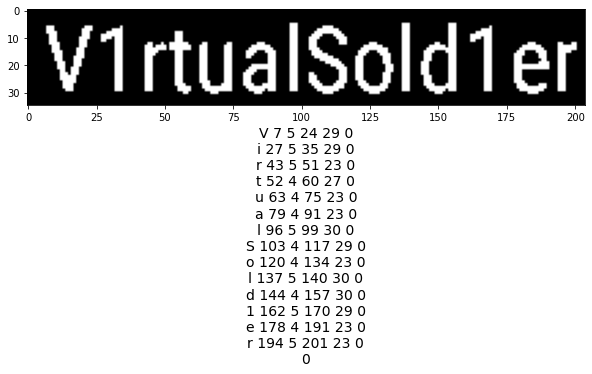

In [0]:
# Apply preprocessing (OTSU)
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'),'OTSU')

x.image_text_to_boxes()
x.print_examples(3)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


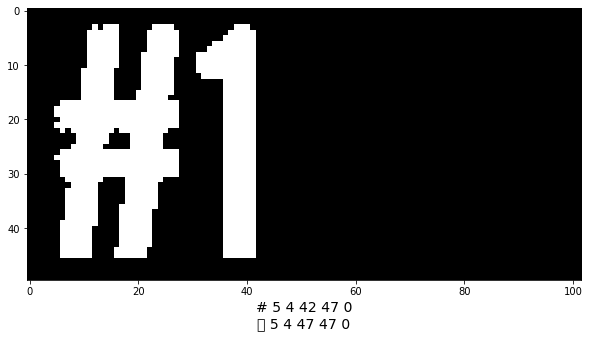

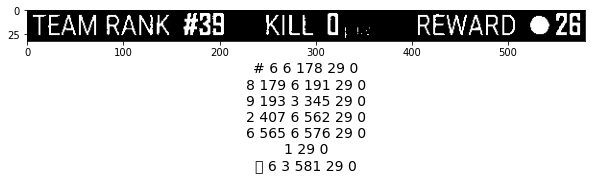

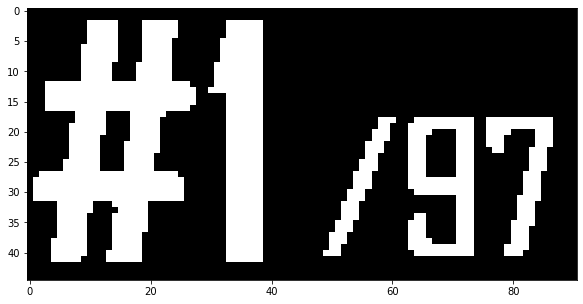

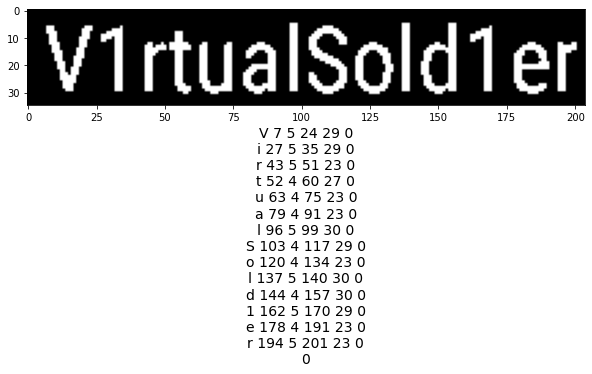

In [0]:
# Apply preprocessing (OTSU)
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'),'OTSU2')

x.image_text_to_boxes()
x.print_examples(3)

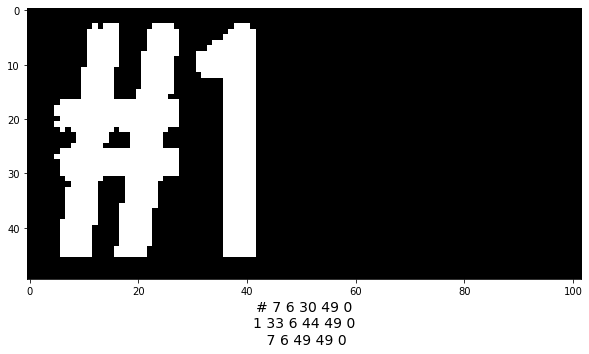

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


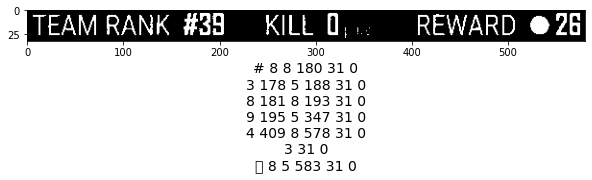

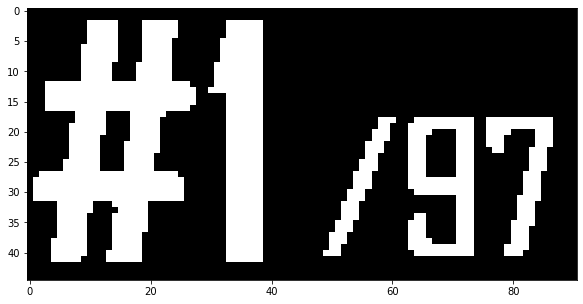

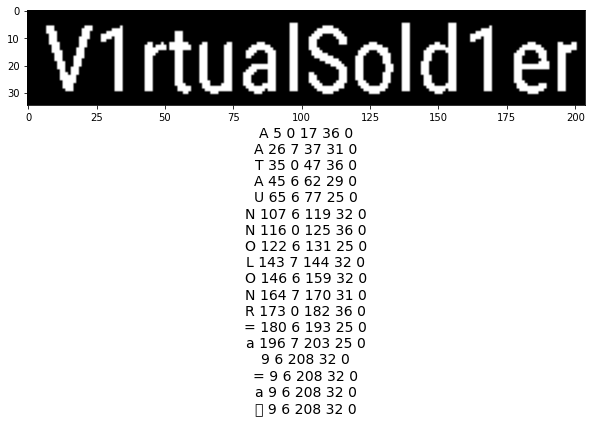

In [0]:
# Apply preprocessing (OTSU)
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'),'OTSU',True)

x.image_text_to_boxes()
x.print_examples(3)

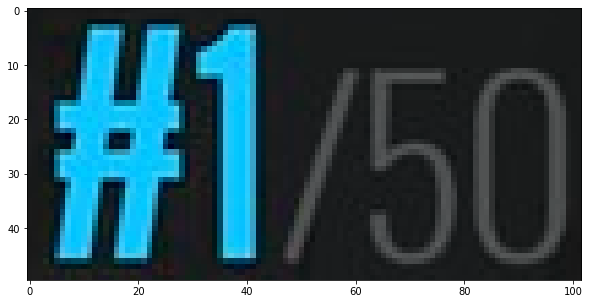

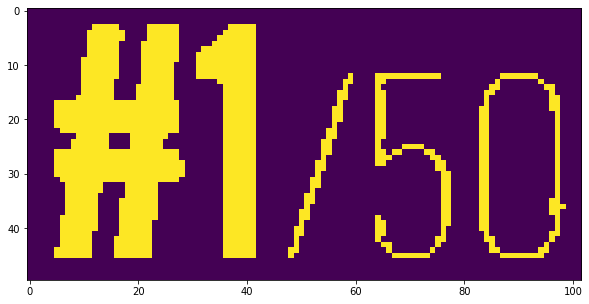

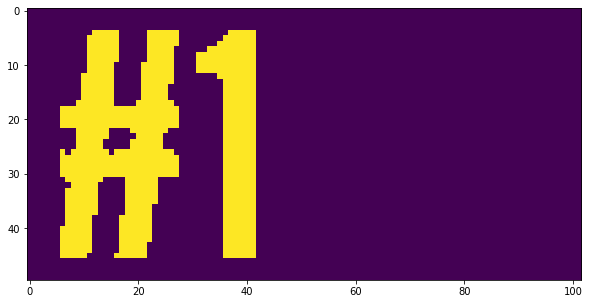

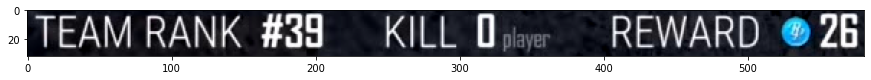

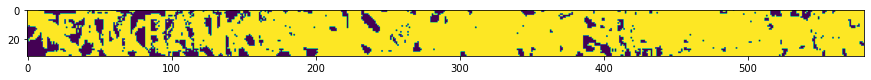

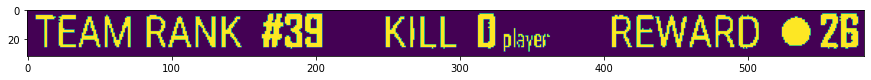

In [0]:
i = 0
for key in x.text_boxes :
  
  image = cv2.imread(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual', key))

  plt.figure(figsize=(15, 5))
  #plt.xlabel(x.text_boxes[key], fontsize=14)
  plt.imshow(denormalize(image.squeeze()))
  plt.show()

  #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret,image1 = cv2.threshold(image1,70,255,cv2.THRESH_BINARY)

  plt.figure(figsize=(15, 5))
  #plt.xlabel(x.text_boxes[key], fontsize=14)
  plt.imshow(denormalize(image1.squeeze()))
  plt.show()

  image2 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret,image2 = cv2.threshold(image2,127,255,cv2.THRESH_BINARY)

  plt.figure(figsize=(15, 5))
  #plt.xlabel(x.text_boxes[key], fontsize=14)
  plt.imshow(denormalize(image2.squeeze()))
  plt.show()

  # Print only a few ones
  if i == 1 : 
    break
  else :
    i+=1

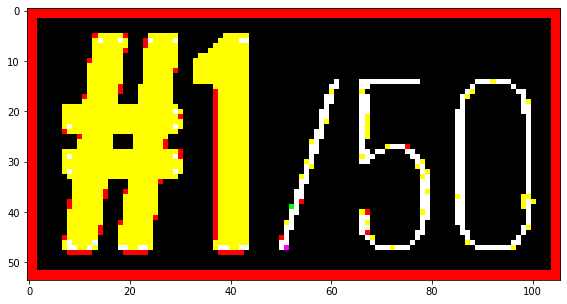

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


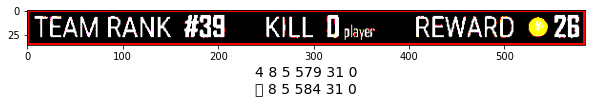

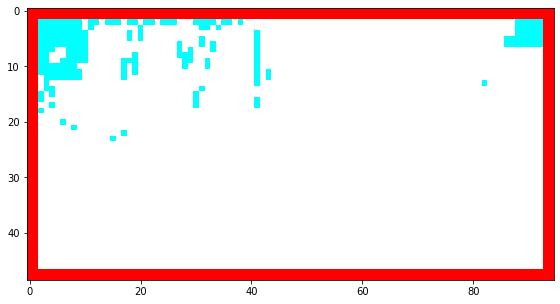

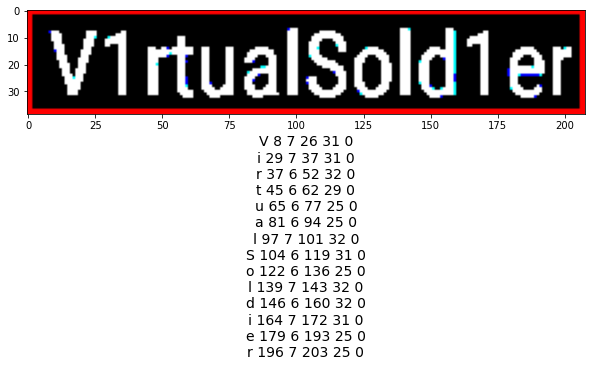

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


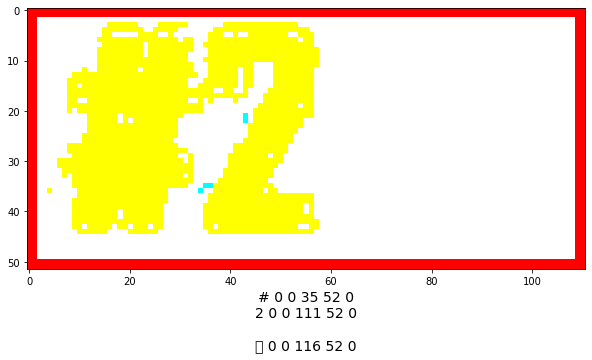

In [0]:
# Apply preprocessing (OTSU)
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'),'BINARY', True, True, False)

x.image_text_to_boxes()
#x.print_examples(3)

# Custom model usage

In [0]:
# Copy trained model to source tesseract folder
os.rename('segmentation/text_extraction/pubg/AgencyFB','segmentation/text_extraction/pubg/AgencyFB.traineddata')
!cp segmentation/text_extraction/pubg/AgencyFB.traineddata /usr/share/tesseract-ocr/5/tessdata/
!ls /usr/share/tesseract-ocr/5/tessdata/

AgencyFB.traineddata  eng.traineddata  pdf.ttf
configs		      osd.traineddata  tessconfigs


In [0]:
# Trained model - ALL IMAGES
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_strings('AgencyFB')

#for item in x.text_boxes:
#  print(x.text_boxes[item])

print(x.evaluate_manual())

0.3296296296296296


In [0]:
# Download results
from google.colab import files
x.eval_table.to_csv('eval.csv', encoding='utf-8')
!zip -r eval.zip eval.csv
files.download("eval.zip")

updating: eval.csv (deflated 59%)


In [0]:
# Trained model - CLASS: score
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_strings('AgencyFB')

#for item in x.text_boxes:
#  print(x.text_boxes[item])

print(x.evaluate_manual('score'))

KeyError: ignored

In [0]:
# Trained model - CLASS: username
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_strings('AgencyFB')

#for item in x.text_boxes:
#  print(x.text_boxes[item])

print(x.evaluate_manual('username'))

In [0]:
# Trained model - CLASS: stat
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_strings('AgencyFB')

#for item in x.text_boxes:
#  print(x.text_boxes[item])

print(x.evaluate_manual('stat'))

In [0]:
# Default model
x = TextProcessor(os.path.join(WORKDIR, 'datasets', 'cropped_images_manual'))

x.image_text_to_strings('eng')

#for item in x.text_boxes:
#  print(x.text_boxes[item])

print(x.evaluate_manual())

0.2851851851851852


In [0]:
# Download results
from google.colab import files
x.eval_table.to_csv('eval2.csv', encoding='utf-8')
!zip -r eval2.zip eval2.csv
files.download("eval2.zip")

  adding: eval2.csv (deflated 59%)
